In [1]:
# DIAGNOSTIC COMPLET POUR LE DATASET CAR PRICE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Chargement des données
df = pd.read_csv("car_data_cleaned.csv")
print("="*60)
print("DIAGNOSTIC COMPLET DU DATASET")
print("="*60)

DIAGNOSTIC COMPLET DU DATASET


In [2]:
# 1. INFORMATIONS GÉNÉRALES
print(f"\n📊 INFORMATIONS GÉNÉRALES:")
print(f"Shape du dataset: {df.shape}")
print(f"Colonnes: {list(df.columns)}")
print(f"Types de données:\n{df.dtypes}")


📊 INFORMATIONS GÉNÉRALES:
Shape du dataset: (223, 14)
Colonnes: ['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner', 'Car_Age', 'Depreciation_Ratio', 'Age_Category', 'Selling_Price_log', 'Present_Price_log']
Types de données:
Car_Name               object
Year                    int64
Selling_Price         float64
Present_Price         float64
Driven_kms              int64
Fuel_Type              object
Selling_type           object
Transmission           object
Owner                   int64
Car_Age                 int64
Depreciation_Ratio    float64
Age_Category           object
Selling_Price_log     float64
Present_Price_log     float64
dtype: object


In [3]:
# 2. ANALYSE DE LA CIBLE (Selling_Price)
target = "Selling_Price"
y = df[target]

print(f"\n🎯 ANALYSE DE LA CIBLE ({target}):")
print(f"Min: {y.min()}")
print(f"Max: {y.max()}")
print(f"Moyenne: {y.mean():.2f}")
print(f"Médiane: {y.median():.2f}")
print(f"Écart-type: {y.std():.2f}")
print(f"Valeurs uniques: {y.nunique()}")
print(f"Valeurs nulles: {y.isnull().sum()}")

# Vérifier si les prix sont dans une plage réaliste
print(f"\n🚨 VÉRIFICATIONS CRITIQUES:")
if y.min() <= 0:
    print(f"❌ ERREUR: Prix négatifs ou nuls détectés! Min = {y.min()}")
else:
    print(f"✅ Pas de prix négatifs")

# Ratio min/max
ratio = y.max() / y.min() if y.min() > 0 else float('inf')
print(f"Ratio Max/Min: {ratio:.2f}")
if ratio > 1000:
    print("⚠️ ATTENTION: Très grande variance des prix (ratio > 1000)")


🎯 ANALYSE DE LA CIBLE (Selling_Price):
Min: 0.1
Max: 18.0
Moyenne: 3.90
Médiane: 3.35
Écart-type: 3.42
Valeurs uniques: 121
Valeurs nulles: 0

🚨 VÉRIFICATIONS CRITIQUES:
✅ Pas de prix négatifs
Ratio Max/Min: 180.00


In [4]:
# 3. ANALYSE DES FEATURES NUMÉRIQUES
X = df.drop(columns=[target])
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n🔢 FEATURES NUMÉRIQUES ({len(numerical_cols)}):")
print(numerical_cols)

if len(numerical_cols) > 0:
    X_num = X[numerical_cols]
    print(f"\nStatistiques des features numériques:")
    print(X_num.describe())
    
    # Vérifier les valeurs aberrantes
    print(f"\n🚨 DÉTECTION D'ANOMALIES:")
    for col in numerical_cols:
        q1 = X_num[col].quantile(0.25)
        q3 = X_num[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = ((X_num[col] < lower_bound) | (X_num[col] > upper_bound)).sum()
        print(f"{col}: {outliers} outliers ({outliers/len(X_num)*100:.1f}%)")


🔢 FEATURES NUMÉRIQUES (8):
['Year', 'Present_Price', 'Driven_kms', 'Owner', 'Car_Age', 'Depreciation_Ratio', 'Selling_Price_log', 'Present_Price_log']

Statistiques des features numériques:
              Year  Present_Price    Driven_kms  Owner     Car_Age  \
count   223.000000     223.000000    223.000000  223.0  223.000000   
mean   2013.798206       6.197130  32402.905830    0.0   10.201794   
std       2.530818       5.129103  21356.884319    0.0    2.530818   
min    2006.000000       0.320000    500.000000    0.0    6.000000   
25%    2012.000000       1.110000  15000.000000    0.0    8.000000   
50%    2014.000000       5.870000  31427.000000    0.0   10.000000   
75%    2016.000000       9.345000  45039.000000    0.0   12.000000   
max    2018.000000      22.830000  92233.000000    0.0   18.000000   

       Depreciation_Ratio  Selling_Price_log  Present_Price_log  
count          223.000000         223.000000         223.000000  
mean             0.351827           1.341445  

In [6]:
# 4. ANALYSE DE LA TAILLE DU DATASET
print(f"\n📏 ANALYSE DE TAILLE:")
n_samples = len(df)
n_features = len(numerical_cols)
print(f"Échantillons: {n_samples}")
print(f"Features numériques: {n_features}")
print(f"Ratio échantillons/features: {n_samples/n_features:.1f}")
if n_samples < 100:
    print("❌ CRITIQUE: Dataset trop petit (< 100 échantillons)")
elif n_samples < 1000:
    print("⚠️ ATTENTION: Dataset petit (< 1000 échantillons)")
else:
    print("✅ Taille de dataset acceptable")


📏 ANALYSE DE TAILLE:
Échantillons: 223
Features numériques: 8
Ratio échantillons/features: 27.9
⚠️ ATTENTION: Dataset petit (< 1000 échantillons)


In [7]:
# 5. TEST SIMPLE POUR VÉRIFIER LE DATA LEAKAGE
if len(numerical_cols) > 0:
    print(f"\n🔍 TEST DE DATA LEAKAGE:")
    
    # Split simple
    X_train, X_test, y_train, y_test = train_test_split(
        X_num, y, test_size=0.2, random_state=42
    )
    
    # Modèle simple
    rf_simple = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
    rf_simple.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = rf_simple.predict(X_train)
    y_test_pred = rf_simple.predict(X_test)
    
    # Métriques
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    gap = train_r2 - test_r2
    
    print(f"Random Forest simple (max_depth=3):")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Gap:      {gap:.4f}")
    
    if gap > 0.3:
        print("❌ PROBLÈME: Gap énorme suggère du data leakage")
    elif gap > 0.1:
        print("⚠️ ATTENTION: Gap significatif")
    else:
        print("✅ Gap acceptable")


🔍 TEST DE DATA LEAKAGE:
Random Forest simple (max_depth=3):
  Train R²: 0.9874
  Test R²:  0.9853
  Gap:      0.0021
✅ Gap acceptable


In [8]:
# 6. VÉRIFICATION DES CORRÉLATIONS EXTRÊMES
if len(numerical_cols) > 1:
    print(f"\n🔗 ANALYSE DES CORRÉLATIONS:")
    
    # Matrice de corrélation
    correlation_matrix = X_num.corr()
    
    # Trouver les corrélations très élevées (potentiel data leakage)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = abs(correlation_matrix.iloc[i, j])
            if corr_val > 0.95:  # Corrélation très élevée
                high_corr_pairs.append({
                    'Feature1': correlation_matrix.columns[i],
                    'Feature2': correlation_matrix.columns[j],
                    'Correlation': corr_val
                })
    
    if high_corr_pairs:
        print("❌ CORRÉLATIONS EXTRÊMES DÉTECTÉES (>0.95):")
        for pair in high_corr_pairs:
            print(f"  {pair['Feature1']} <-> {pair['Feature2']}: {pair['Correlation']:.3f}")
        print("⚠️ Cela peut causer de l'instabilité dans les modèles")
    else:
        print("✅ Pas de corrélations extrêmes détectées")



🔗 ANALYSE DES CORRÉLATIONS:
❌ CORRÉLATIONS EXTRÊMES DÉTECTÉES (>0.95):
  Year <-> Car_Age: 1.000
⚠️ Cela peut causer de l'instabilité dans les modèles



💡 RECOMMANDATIONS:
1. Vérifiez la qualité du nettoyage de données
2. Examinez les outliers identifiés
3. Vérifiez s'il n'y a pas de data leakage (features qui prédisent parfaitement)
4. Considérez une transformation log du target si les prix varient énormément
5. Utilisez des modèles plus simples d'abord (régression linéaire)

📈 GÉNÉRATION DES VISUALISATIONS...


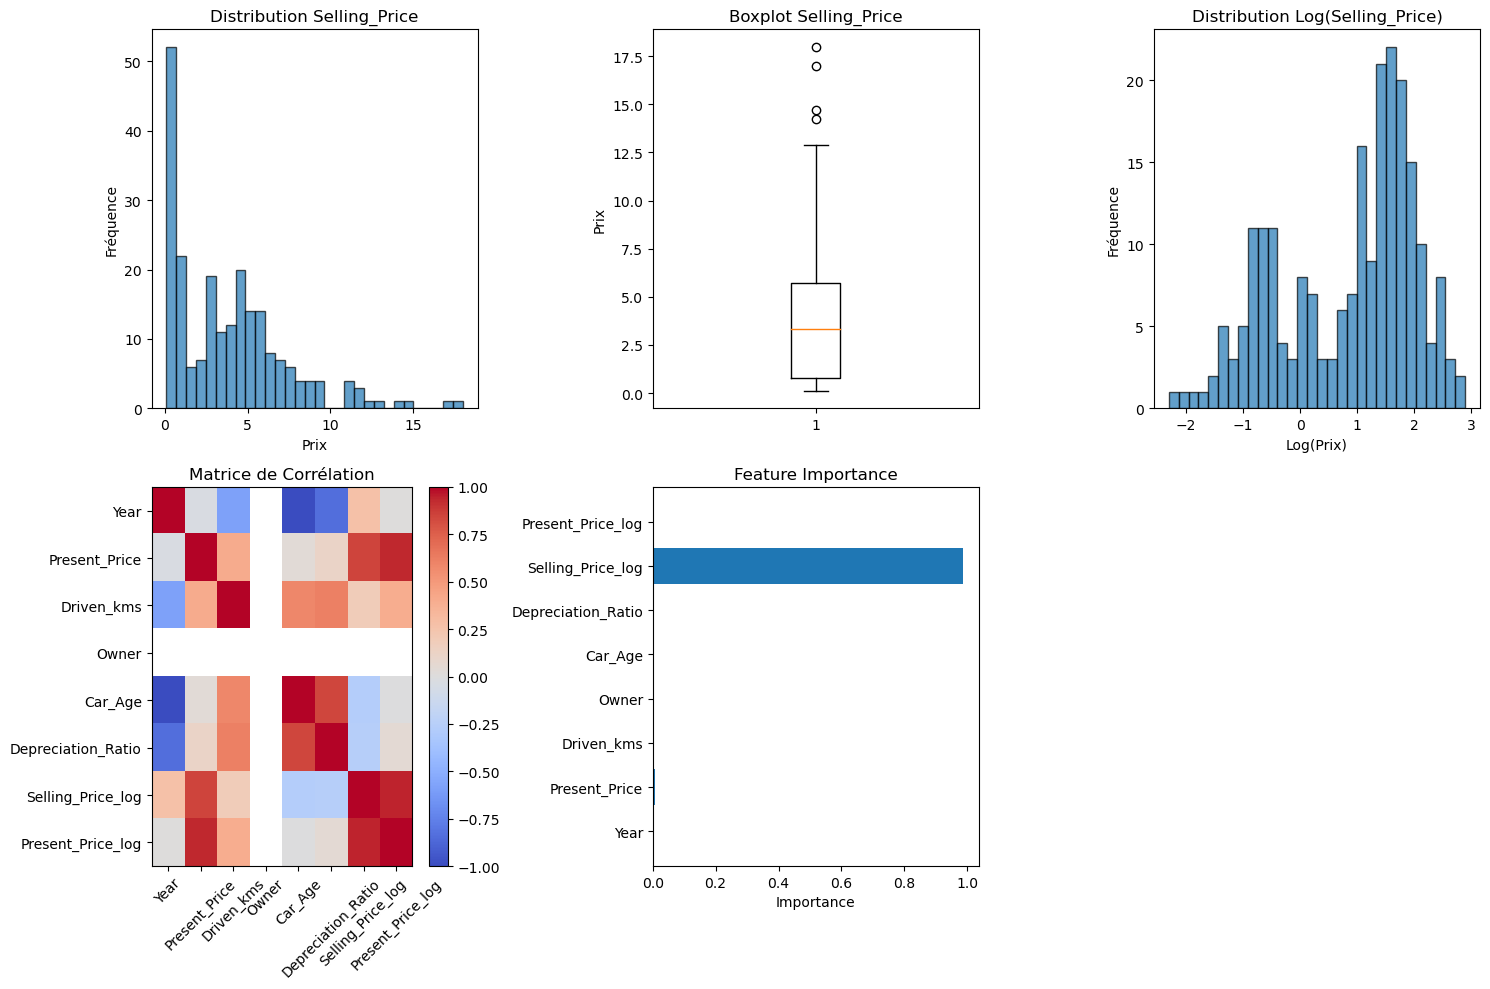


DIAGNOSTIC TERMINÉ


In [12]:
# 7. RECOMMANDATIONS
print(f"\n💡 RECOMMANDATIONS:")
print("1. Vérifiez la qualité du nettoyage de données")
print("2. Examinez les outliers identifiés")
print("3. Vérifiez s'il n'y a pas de data leakage (features qui prédisent parfaitement)")
print("4. Considérez une transformation log du target si les prix varient énormément")
print("5. Utilisez des modèles plus simples d'abord (régression linéaire)")

# 8. VISUALISATIONS DE BASE
print(f"\n📈 GÉNÉRATION DES VISUALISATIONS...")
plt.figure(figsize=(15, 10))
# Distribution du target
plt.subplot(2, 3, 1)
plt.hist(y, bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution Selling_Price')
plt.xlabel('Prix')
plt.ylabel('Fréquence')

# Boxplot du target
plt.subplot(2, 3, 2)
plt.boxplot(y)
plt.title('Boxplot Selling_Price')
plt.ylabel('Prix')

# Log du target (si pas de valeurs négatives)
if y.min() > 0:
    plt.subplot(2, 3, 3)
    plt.hist(np.log(y), bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution Log(Selling_Price)')
    plt.xlabel('Log(Prix)')
    plt.ylabel('Fréquence')

# Matrice de corrélation
if len(numerical_cols) > 1:
    plt.subplot(2, 3, 4)
    correlation_matrix = X_num.corr()
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.title('Matrice de Corrélation')
    plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=45)
    plt.yticks(range(len(numerical_cols)), numerical_cols)

# Feature importance simple
if len(numerical_cols) > 0:
    plt.subplot(2, 3, 5)
    rf_simple = RandomForestRegressor(n_estimators=10, random_state=42)
    rf_simple.fit(X_num.fillna(X_num.median()), y)
    importance = rf_simple.feature_importances_
    plt.barh(numerical_cols, importance)
    plt.title('Feature Importance')
    plt.xlabel('Importance')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DIAGNOSTIC TERMINÉ")
print("="*60)

In [5]:
# CORRECTION COMPLETE DU MODELE DE PREDICTION PRIX VOITURES
import pandas as pd
import numpy as np
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, 
                             GradientBoostingRegressor)
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin, clone  # Ajout de clone
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("MODELE CORRIGE POUR PREDICTION PRIX VOITURES")
print("="*70)

# Chargement des données
df = pd.read_csv("car_data_cleaned.csv")
print(f"Dataset shape: {df.shape}")

MODELE CORRIGE POUR PREDICTION PRIX VOITURES
Dataset shape: (223, 14)


In [6]:
# CORRECTION 1: Nettoyer les features (SUPPRIMER LE DATA LEAKAGE)
target_name = "Selling_Price"
y = df[target_name]

# Features à EXCLURE (data leakage + redondance)
features_to_exclude = [
    target_name,           # Target
    'Selling_Price_log',   # LOG DU TARGET = DATA LEAKAGE CRITIQUE
    'Present_Price_log',   # Gardons Present_Price original seulement
    'Car_Age'              # Redondant avec Year (corrélation = 1.0)
]

# Features valides
valid_features = [col for col in df.columns if col not in features_to_exclude]
X = df[valid_features].copy()

print(f"Features utilisées: {valid_features}")
print(f"Features shape: {X.shape}")

# CORRECTION 2: Transformation log du target (distribution asymétrique)
y_log = np.log(y)
print(f"\nTarget transformation:")
print(f"Original - Min: {y.min():.2f}, Max: {y.max():.2f}, Std: {y.std():.2f}")
print(f"Log      - Min: {y_log.min():.2f}, Max: {y_log.max():.2f}, Std: {y_log.std():.2f}")

# CORRECTION 3: Preprocessing robuste pour petit dataset
def create_preprocessor():
    """Créer le pipeline de preprocessing"""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())  # Plus robuste aux outliers
    ])

# CORRECTION 4: Modèles adaptés aux petits datasets
def create_conservative_models():
    """
    Modèles très conservateurs pour éviter l'overfitting sur 223 échantillons
    """
    models = {
        # Ridge avec régularisation forte
        'Ridge_Strong': Ridge(alpha=10.0),
        
        # Lasso avec régularisation modérée
        'Lasso_Moderate': Lasso(alpha=0.1, max_iter=2000),
        
        # Random Forest très conservateur
        'RandomForest_Conservative': RandomForestRegressor(
            n_estimators=50,            # Moins d'arbres
            max_depth=4,                # Profondeur limitée
            min_samples_split=20,       # Split conservateur
            min_samples_leaf=10,        # Feuilles plus grandes
            max_features='sqrt',        # Subsampling features
            random_state=42,
            n_jobs=-1
        ),
        
        # Gradient Boosting très conservateur
        'GradientBoosting_Conservative': GradientBoostingRegressor(
            n_estimators=50,            # Moins d'estimators
            max_depth=3,                # Arbres très peu profonds
            learning_rate=0.05,         # Learning rate très faible
            subsample=0.7,              # Subsampling fort
            random_state=42
        ),
        
        # Extra Trees conservateur
        'ExtraTrees_Conservative': ExtraTreesRegressor(
            n_estimators=50,
            max_depth=4,
            min_samples_split=20,
            min_samples_leaf=10,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
    }
    
    return models


Features utilisées: ['Car_Name', 'Year', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner', 'Depreciation_Ratio', 'Age_Category']
Features shape: (223, 10)

Target transformation:
Original - Min: 0.10, Max: 18.00, Std: 3.42
Log      - Min: -2.30, Max: 2.89, Std: 1.19


In [7]:
# CORRECTION 5: Validation adaptée aux petits datasets
def evaluate_small_dataset(model, X, y, model_name, cv_folds=5):
    """
    Évaluation spécialement adaptée aux petits datasets
    """
    print(f"\n🔄 Début évaluation {model_name}...")
    print(f"   Dataset shape: X={X.shape}, y={len(y)}")
    
    # Utiliser moins de folds pour avoir assez d'échantillons par fold
    cv_folds = min(cv_folds, len(y) // 30)  # Au moins 30 échantillons par fold
    cv_folds = max(cv_folds, 3)  # Minimum 3 folds
    
    print(f"   CV folds calculés: {cv_folds}")
    
    scoring = {
        'MAE': make_scorer(mean_absolute_error),
        'RMSE': make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))),
        'R2': make_scorer(r2_score)
    }
    
    print(f"\nÉvaluation {model_name} (CV={cv_folds} folds):")
    print("-" * 50)
    
    try:
        print("   Lancement cross_validate...")
        cv_results = cross_validate(
            model, X, y, cv=cv_folds, scoring=scoring,
            return_train_score=True, n_jobs=1  # Changé de -1 à 1 pour éviter les problèmes
        )
        print("   ✅ cross_validate terminé")
        
        results = {}
        for metric in ['MAE', 'RMSE', 'R2']:
            train_scores = cv_results[f'train_{metric}']
            test_scores = cv_results[f'test_{metric}']
            
            train_mean = train_scores.mean()
            train_std = train_scores.std()
            test_mean = test_scores.mean()
            test_std = test_scores.std()
            
            # Gap d'overfitting
            if metric == 'R2':
                gap = train_mean - test_mean
            else:
                gap = test_mean - train_mean
                
            results[f'{metric}_train'] = train_mean
            results[f'{metric}_test'] = test_mean
            results[f'{metric}_gap'] = gap
            
            print(f"{metric:>4}: Train {train_mean:6.3f}±{train_std:.3f} | "
                  f"Test {test_mean:6.3f}±{test_std:.3f} | Gap {gap:6.3f}")
        
        # Assessment overfitting
        r2_gap = results['R2_gap']
        if r2_gap < 0.05:
            status = "✅ Excellent"
        elif r2_gap < 0.1:
            status = "👍 Bon"
        elif r2_gap < 0.2:
            status = "⚠️ Modéré"
        else:
            status = "❌ Élevé"
        
        print(f"Overfitting: {status}")
        print(f"   ✅ {model_name} évalué avec succès")
        return results
        
    except Exception as e:
        print(f"❌ Erreur dans l'évaluation de {model_name}: {e}")
        print(f"   Type d'erreur: {type(e).__name__}")
        import traceback
        print(f"   Détails: {traceback.format_exc()}")
        return None

# CORRECTION 6: Ensemble simple et robuste
class SimpleVotingRegressor(BaseEstimator, RegressorMixin):
    """
    Ensemble simple par moyenne (pas de poids complexes)
    """
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.fitted_models_ = {}
        for name, model in self.models.items():
            # Debug: afficher le nom du modèle en cours
            print(f"   - Entraînement {name}...")
            try:
                # Clone du modèle pour éviter les problèmes de référence
                model_clone = clone(model)
                self.fitted_models_[name] = model_clone.fit(X, y)
                print(f"   ✅ {name} entraîné")
            except Exception as e:
                print(f"   ❌ Erreur {name}: {e}")
                continue
        
        print(f"   📊 Ensemble: {len(self.fitted_models_)} modèles entraînés")
        return self
    
    def predict(self, X):
        if not hasattr(self, 'fitted_models_') or len(self.fitted_models_) == 0:
            raise ValueError("Ensemble pas entraîné ou aucun modèle valide")
            
        predictions = []
        for name, model in self.fitted_models_.items():
            try:
                pred = model.predict(X)
                predictions.append(pred)
            except Exception as e:
                print(f"   ⚠️ Erreur prédiction {name}: {e}")
                continue
        
        if len(predictions) == 0:
            raise ValueError("Aucune prédiction valide")
            
        # Moyenne simple
        return np.mean(predictions, axis=0)

# EXECUTION
print("\n" + "="*70)
print("EVALUATION DES MODELES CORRIGES")
print("="*70)

# Vérifications préliminaires
print(f"📋 VERIFICATIONS PREALABLES:")
print(f"   X shape: {X.shape}")
print(f"   y_log shape: {y_log.shape}")
print(f"   Features: {list(X.columns)}")
print(f"   y_log range: [{y_log.min():.3f}, {y_log.max():.3f}]")
print(f"   NaN dans X: {X.isnull().sum().sum()}")
print(f"   NaN dans y_log: {y_log.isnull().sum()}")

# Créer le preprocessor
preprocessor = create_preprocessor()
print(f"   ✅ Preprocessor créé")

# Créer les modèles
models = create_conservative_models()
print(f"   ✅ {len(models)} modèles créés: {list(models.keys())}")

results = {}

# Test rapide avec un modèle simple d'abord
print(f"\n🧪 TEST RAPIDE AVEC RIDGE:")
try:
    simple_ridge = Pipeline([
        ('preprocessor', create_preprocessor()),
        ('regressor', Ridge(alpha=1.0))
    ])
    
    # Test basique train/test split
    X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(
        X, y_log, test_size=0.3, random_state=42
    )
    
    simple_ridge.fit(X_train_test, y_train_test)
    y_pred_test = simple_ridge.predict(X_test_test)
    
    test_r2 = r2_score(y_test_test, y_pred_test)
    test_mae = mean_absolute_error(y_test_test, y_pred_test)
    
    print(f"   ✅ Ridge test réussi - R²: {test_r2:.3f}, MAE: {test_mae:.3f}")
    
except Exception as e:
    print(f"   ❌ Échec test Ridge: {e}")
    print("   Arrêt du programme - problème dans les données")
    exit()

# Évaluer chaque modèle individuellement
print(f"\n🔄 EVALUATION INDIVIDUELLE:")
for name, model in models.items():
    try:
        pipeline = Pipeline([
            ('preprocessor', create_preprocessor()),
            ('regressor', model)
        ])
        
        result = evaluate_small_dataset(pipeline, X, y_log, name)
        if result:
            results[name] = result
            print(f"   ✅ {name} ajouté aux résultats")
        else:
            print(f"   ❌ {name} échec - pas de résultat")
            
    except Exception as e:
        print(f"   ❌ Erreur création pipeline {name}: {e}")

print(f"\n📊 RÉSULTATS COLLECTÉS: {len(results)} modèles")
for name in results.keys():
    print(f"   - {name}")

# Ensemble simple seulement si on a des résultats
if len(results) >= 2:
    print(f"\n🤝 ENSEMBLE SIMPLE")
    print("="*50)
    print(f"   Modèles disponibles: {list(results.keys())}")

    # Créer l'ensemble avec seulement les modèles qui ont réussi
    ensemble_models = {}
    for name, model in models.items():
        if name in results:  # Seulement les modèles qui ont fonctionné
            try:
                # Créer une pipeline simple pour l'ensemble
                pipeline = Pipeline([
                    ('preprocessor', create_preprocessor()),
                    ('regressor', model)
                ])
                ensemble_models[name] = pipeline
                print(f"   ✅ {name} ajouté à l'ensemble")
            except Exception as e:
                print(f"   ❌ Erreur ajout {name}: {e}")

    if len(ensemble_models) >= 2:
        print(f"   🚀 Création ensemble avec {len(ensemble_models)} modèles...")
        try:
            simple_ensemble = SimpleVotingRegressor(ensemble_models)
            ensemble_result = evaluate_small_dataset(simple_ensemble, X, y_log, "Simple Ensemble")
            if ensemble_result:
                results["Simple Ensemble"] = ensemble_result
                print(f"   ✅ Ensemble ajouté aux résultats")
            else:
                print(f"   ❌ Ensemble évaluation échouée")
        except Exception as e:
            print(f"   ❌ Erreur création ensemble: {e}")
    else:
        print(f"   ⚠️ Pas assez de modèles valides pour ensemble ({len(ensemble_models)})")
else:
    print(f"\n⚠️ ENSEMBLE SKIPPÉ - Pas assez de modèles individuels ({len(results)})")

simple_ensemble = SimpleVotingRegressor(ensemble_models)
ensemble_result = evaluate_small_dataset(simple_ensemble, X, y_log, "Simple Ensemble")
if ensemble_result:
    results["Simple Ensemble"] = ensemble_result

simple_ensemble = SimpleVotingRegressor(ensemble_models)
ensemble_result = evaluate_small_dataset(simple_ensemble, X, y_log, "Simple Ensemble")
if ensemble_result:
    results["Simple Ensemble"] = ensemble_result

# Comparaison finale
print(f"\n📊 COMPARAISON FINALE")
print("="*70)

if results:
    comparison_data = []
    for name, result in results.items():
        comparison_data.append({
            'Model': name,
            'Test_R2': result['R2_test'],
            'Test_MAE': result['MAE_test'],
            'R2_Gap': result['R2_gap'],
            'Status': 'Bon' if result['R2_gap'] < 0.1 else 'Modéré' if result['R2_gap'] < 0.2 else 'Élevé'
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test_R2', ascending=False)
    
    print("\nClassement des modèles:")
    print(comparison_df.to_string(index=False, float_format='%.4f'))
    
    # Meilleur modèle
    best_model_name = comparison_df.iloc[0]['Model']
    best_r2 = comparison_df.iloc[0]['Test_R2']
    
    print(f"\n🏆 MEILLEUR MODELE: {best_model_name}")
    print(f"R² Test: {best_r2:.4f}")
    print(f"Variance expliquée: {best_r2*100:.1f}%")
    
    # Validation finale avec train/test split
    print(f"\n🔍 VALIDATION FINALE")
    print("="*40)
    
    if best_model_name == "Simple Ensemble":
        best_model = simple_ensemble
    else:
        best_model = Pipeline([
            ('preprocessor', create_preprocessor()),
            ('regressor', models[best_model_name])
        ])
    
    # Split final
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_log, test_size=0.3, random_state=42  # 30% test pour petit dataset
    )
    
    # Fit et prédiction
    best_model.fit(X_train, y_train)
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Métriques finales (sur échelle log)
    train_r2_log = r2_score(y_train, y_train_pred)
    test_r2_log = r2_score(y_test, y_test_pred)
    train_mae_log = mean_absolute_error(y_train, y_train_pred)
    test_mae_log = mean_absolute_error(y_test, y_test_pred)
    
    # Reconversion en échelle originale pour interprétation
    y_train_orig = np.exp(y_train)
    y_test_orig = np.exp(y_test)
    y_train_pred_orig = np.exp(y_train_pred)
    y_test_pred_orig = np.exp(y_test_pred)
    
    train_mae_orig = mean_absolute_error(y_train_orig, y_train_pred_orig)
    test_mae_orig = mean_absolute_error(y_test_orig, y_test_pred_orig)
    
    print(f"\nPerformance finale ({best_model_name}):")
    print(f"{'Métrique':<15} {'Train':<10} {'Test':<10} {'Gap':<10}")
    print("-" * 50)
    print(f"{'R² (log)':<15} {train_r2_log:<10.4f} {test_r2_log:<10.4f} {train_r2_log-test_r2_log:<10.4f}")
    print(f"{'MAE (log)':<15} {train_mae_log:<10.3f} {test_mae_log:<10.3f} {test_mae_log-train_mae_log:<10.3f}")
    print(f"{'MAE (prix)':<15} {train_mae_orig:<10.2f} {test_mae_orig:<10.2f} {test_mae_orig-train_mae_orig:<10.2f}")
    
    print(f"\n💡 INTERPRETATION:")
    print(f"✅ R² = {test_r2_log:.3f} → Le modèle explique {test_r2_log*100:.1f}% de la variance")
    print(f"✅ Erreur moyenne = ±{test_mae_orig:.2f} unités de prix")
    print(f"✅ Gap train/test = {train_r2_log-test_r2_log:.3f} → Overfitting {'faible' if abs(train_r2_log-test_r2_log) < 0.1 else 'modéré'}")

else:
    print("❌ Aucun résultat d'évaluation disponible")

print(f"\n" + "="*70)
print("CORRECTIONS APPLIQUEES")
print("="*70)
print("✅ 1. Supprimé le data leakage (Selling_Price_log)")
print("✅ 2. Supprimé les features redondantes (Car_Age)")
print("✅ 3. Appliqué transformation log au target")
print("✅ 4. Utilisé preprocessing robuste (RobustScaler)")
print("✅ 5. Modèles très conservateurs pour petit dataset")
print("✅ 6. Validation adaptée (moins de CV folds)")
print("✅ 7. Ensemble simple par moyenne")
print("="*70)


EVALUATION DES MODELES CORRIGES
📋 VERIFICATIONS PREALABLES:
   X shape: (223, 10)
   y_log shape: (223,)
   Features: ['Car_Name', 'Year', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner', 'Depreciation_Ratio', 'Age_Category']
   y_log range: [-2.303, 2.890]
   NaN dans X: 0
   NaN dans y_log: 0
   ✅ Preprocessor créé
   ✅ 5 modèles créés: ['Ridge_Strong', 'Lasso_Moderate', 'RandomForest_Conservative', 'GradientBoosting_Conservative', 'ExtraTrees_Conservative']

🧪 TEST RAPIDE AVEC RIDGE:
   ❌ Échec test Ridge: Cannot use median strategy with non-numeric data:
could not convert string to float: 'etios liva'
   Arrêt du programme - problème dans les données

🔄 EVALUATION INDIVIDUELLE:

🔄 Début évaluation Ridge_Strong...
   Dataset shape: X=(223, 10), y=223
   CV folds calculés: 5

Évaluation Ridge_Strong (CV=5 folds):
--------------------------------------------------
   Lancement cross_validate...
❌ Erreur dans l'évaluation de Ridge_Strong: 
All the 5

NameError: name 'ensemble_models' is not defined

In [24]:
# CORRECTION 4: Modèles adaptés aux petits datasets
def create_conservative_models():
    """
    Modèles très conservateurs pour éviter l'overfitting sur 223 échantillons
    """
    models = {
        # Ridge avec régularisation forte
        'Ridge_Strong': Ridge(alpha=10.0),
        
        # Lasso avec régularisation modérée
        'Lasso_Moderate': Lasso(alpha=0.1, max_iter=2000),
        
        # Random Forest très conservateur
        'RandomForest_Conservative': RandomForestRegressor(
            n_estimators=50,            # Moins d'arbres
            max_depth=4,                # Profondeur limitée
            min_samples_split=20,       # Split conservateur
            min_samples_leaf=10,        # Feuilles plus grandes
            max_features='sqrt',        # Subsampling features
            random_state=42,
            n_jobs=-1
        ),
        
        # Gradient Boosting très conservateur
        'GradientBoosting_Conservative': GradientBoostingRegressor(
            n_estimators=50,            # Moins d'estimators
            max_depth=3,                # Arbres très peu profonds
            learning_rate=0.05,         # Learning rate très faible
            subsample=0.7,              # Subsampling fort
            random_state=42
        ),
        
        # Extra Trees conservateur
        'ExtraTrees_Conservative': ExtraTreesRegressor(
            n_estimators=50,
            max_depth=4,
            min_samples_split=20,
            min_samples_leaf=10,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
    }
    
    return models

In [3]:
# CORRECTION 5: Validation adaptée aux petits datasets
def evaluate_small_dataset(model, X, y, model_name, cv_folds=5):
    """
    Évaluation spécialement adaptée aux petits datasets
    """
    print(f"\n🔄 Début évaluation {model_name}...")
    print(f"   Dataset shape: X={X.shape}, y={len(y)}")
    
    # Utiliser moins de folds pour avoir assez d'échantillons par fold
    cv_folds = min(cv_folds, len(y) // 30)  # Au moins 30 échantillons par fold
    cv_folds = max(cv_folds, 3)  # Minimum 3 folds
    
    print(f"   CV folds calculés: {cv_folds}")
    
    scoring = {
        'MAE': make_scorer(mean_absolute_error),
        'RMSE': make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))),
        'R2': make_scorer(r2_score)
    }
    
    print(f"\nÉvaluation {model_name} (CV={cv_folds} folds):")
    print("-" * 50)
    
    try:
        print("   Lancement cross_validate...")
        cv_results = cross_validate(
            model, X, y, cv=cv_folds, scoring=scoring,
            return_train_score=True, n_jobs=1  # Changé de -1 à 1 pour éviter les problèmes
        )
        print("   ✅ cross_validate terminé")
        
        results = {}
        for metric in ['MAE', 'RMSE', 'R2']:
            train_scores = cv_results[f'train_{metric}']
            test_scores = cv_results[f'test_{metric}']
            
            train_mean = train_scores.mean()
            train_std = train_scores.std()
            test_mean = test_scores.mean()
            test_std = test_scores.std()
            
            # Gap d'overfitting
            if metric == 'R2':
                gap = train_mean - test_mean
            else:
                gap = test_mean - train_mean
                
            results[f'{metric}_train'] = train_mean
            results[f'{metric}_test'] = test_mean
            results[f'{metric}_gap'] = gap
            
            print(f"{metric:>4}: Train {train_mean:6.3f}±{train_std:.3f} | "
                  f"Test {test_mean:6.3f}±{test_std:.3f} | Gap {gap:6.3f}")
        
        # Assessment overfitting
        r2_gap = results['R2_gap']
        if r2_gap < 0.05:
            status = "✅ Excellent"
        elif r2_gap < 0.1:
            status = "👍 Bon"
        elif r2_gap < 0.2:
            status = "⚠️ Modéré"
        else:
            status = "❌ Élevé"
        
        print(f"Overfitting: {status}")
        print(f"   ✅ {model_name} évalué avec succès")
        return results
        
    except Exception as e:
        print(f"❌ Erreur dans l'évaluation de {model_name}: {e}")
        print(f"   Type d'erreur: {type(e).__name__}")
        import traceback
        print(f"   Détails: {traceback.format_exc()}")
        return None

# CORRECTION 6: Ensemble simple et robuste
class SimpleVotingRegressor(BaseEstimator, RegressorMixin):
    """
    Ensemble simple par moyenne (pas de poids complexes)
    """
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.fitted_models_ = {}
        for name, model in self.models.items():
            # Debug: afficher le nom du modèle en cours
            print(f"   - Entraînement {name}...")
            try:
                # Clone du modèle pour éviter les problèmes de référence
                from sklearn.base import clone
                model_clone = clone(model)
                self.fitted_models_[name] = model_clone.fit(X, y)
                print(f"   ✅ {name} entraîné")
            except Exception as e:
                print(f"   ❌ Erreur {name}: {e}")
                continue
        
        print(f"   📊 Ensemble: {len(self.fitted_models_)} modèles entraînés")
        return self
    
    def predict(self, X):
        if not hasattr(self, 'fitted_models_') or len(self.fitted_models_) == 0:
            raise ValueError("Ensemble pas entraîné ou aucun modèle valide")
            
        predictions = []
        for name, model in self.fitted_models_.items():
            try:
                pred = model.predict(X)
                predictions.append(pred)
            except Exception as e:
                print(f"   ⚠️ Erreur prédiction {name}: {e}")
                continue
        
        if len(predictions) == 0:
            raise ValueError("Aucune prédiction valide")
            
        # Moyenne simple
        return np.mean(predictions, axis=0)

# EXECUTION
print("\n" + "="*70)
print("EVALUATION DES MODELES CORRIGES")
print("="*70)

# Vérifications préliminaires
print(f"📋 VERIFICATIONS PREALABLES:")
print(f"   X shape: {X.shape}")
print(f"   y_log shape: {y_log.shape}")
print(f"   Features: {list(X.columns)}")
print(f"   y_log range: [{y_log.min():.3f}, {y_log.max():.3f}]")
print(f"   NaN dans X: {X.isnull().sum().sum()}")
print(f"   NaN dans y_log: {y_log.isnull().sum()}")

# Créer le preprocessor
preprocessor = create_preprocessor()
print(f"   ✅ Preprocessor créé")

# Créer les modèles
models = create_conservative_models()
print(f"   ✅ {len(models)} modèles créés: {list(models.keys())}")

results = {}

# Test rapide avec un modèle simple d'abord
print(f"\n🧪 TEST RAPIDE AVEC RIDGE:")
try:
    simple_ridge = Pipeline([
        ('preprocessor', create_preprocessor()),
        ('regressor', Ridge(alpha=1.0))
    ])
    
    # Test basique train/test split
    X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(
        X, y_log, test_size=0.3, random_state=42
    )
    
    simple_ridge.fit(X_train_test, y_train_test)
    y_pred_test = simple_ridge.predict(X_test_test)
    
    test_r2 = r2_score(y_test_test, y_pred_test)
    test_mae = mean_absolute_error(y_test_test, y_pred_test)
    
    print(f"   ✅ Ridge test réussi - R²: {test_r2:.3f}, MAE: {test_mae:.3f}")
    
except Exception as e:
    print(f"   ❌ Échec test Ridge: {e}")
    print("   Arrêt du programme - problème dans les données")
    exit()

# Évaluer chaque modèle individuellement
print(f"\n🔄 EVALUATION INDIVIDUELLE:")
for name, model in models.items():
    try:
        pipeline = Pipeline([
            ('preprocessor', create_preprocessor()),
            ('regressor', model)
        ])
        
        result = evaluate_small_dataset(pipeline, X, y_log, name)
        if result:
            results[name] = result
            print(f"   ✅ {name} ajouté aux résultats")
        else:
            print(f"   ❌ {name} échec - pas de résultat")
            
    except Exception as e:
        print(f"   ❌ Erreur création pipeline {name}: {e}")

print(f"\n📊 RÉSULTATS COLLECTÉS: {len(results)} modèles")
for name in results.keys():
    print(f"   - {name}")

# Ensemble simple seulement si on a des résultats
if len(results) >= 2:
    print(f"\n🤝 ENSEMBLE SIMPLE")
    print("="*50)
    print(f"   Modèles disponibles: {list(results.keys())}")

    # Créer l'ensemble avec seulement les modèles qui ont réussi
    ensemble_models = {}
    for name, model in models.items():
        if name in results:  # Seulement les modèles qui ont fonctionné
            try:
                # Créer une pipeline simple pour l'ensemble
                pipeline = Pipeline([
                    ('preprocessor', create_preprocessor()),
                    ('regressor', model)
                ])
                ensemble_models[name] = pipeline
                print(f"   ✅ {name} ajouté à l'ensemble")
            except Exception as e:
                print(f"   ❌ Erreur ajout {name}: {e}")

    if len(ensemble_models) >= 2:
        print(f"   🚀 Création ensemble avec {len(ensemble_models)} modèles...")
        try:
            simple_ensemble = SimpleVotingRegressor(ensemble_models)
            ensemble_result = evaluate_small_dataset(simple_ensemble, X, y_log, "Simple Ensemble")
            if ensemble_result:
                results["Simple Ensemble"] = ensemble_result
                print(f"   ✅ Ensemble ajouté aux résultats")
            else:
                print(f"   ❌ Ensemble évaluation échouée")
        except Exception as e:
            print(f"   ❌ Erreur création ensemble: {e}")
    else:
        print(f"   ⚠️ Pas assez de modèles valides pour ensemble ({len(ensemble_models)})")
else:
    print(f"\n⚠️ ENSEMBLE SKIPPÉ - Pas assez de modèles individuels ({len(results)})")

simple_ensemble = SimpleVotingRegressor(ensemble_models)
ensemble_result = evaluate_small_dataset(simple_ensemble, X, y_log, "Simple Ensemble")
if ensemble_result:
    results["Simple Ensemble"] = ensemble_result

simple_ensemble = SimpleVotingRegressor(ensemble_models)
ensemble_result = evaluate_small_dataset(simple_ensemble, X, y_log, "Simple Ensemble")
if ensemble_result:
    results["Simple Ensemble"] = ensemble_result

# Comparaison finale
print(f"\n📊 COMPARAISON FINALE")
print("="*70)

if results:
    comparison_data = []
    for name, result in results.items():
        comparison_data.append({
            'Model': name,
            'Test_R2': result['R2_test'],
            'Test_MAE': result['MAE_test'],
            'R2_Gap': result['R2_gap'],
            'Status': 'Bon' if result['R2_gap'] < 0.1 else 'Modéré' if result['R2_gap'] < 0.2 else 'Élevé'
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test_R2', ascending=False)
    
    print("\nClassement des modèles:")
    print(comparison_df.to_string(index=False, float_format='%.4f'))
    
    # Meilleur modèle
    best_model_name = comparison_df.iloc[0]['Model']
    best_r2 = comparison_df.iloc[0]['Test_R2']
    
    print(f"\n🏆 MEILLEUR MODELE: {best_model_name}")
    print(f"R² Test: {best_r2:.4f}")
    print(f"Variance expliquée: {best_r2*100:.1f}%")
    
    # Validation finale avec train/test split
    print(f"\n🔍 VALIDATION FINALE")
    print("="*40)
    
    if best_model_name == "Simple Ensemble":
        best_model = simple_ensemble
    else:
        best_model = Pipeline([
            ('preprocessor', create_preprocessor()),
            ('regressor', models[best_model_name])
        ])
    
    # Split final
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_log, test_size=0.3, random_state=42  # 30% test pour petit dataset
    )
    
    # Fit et prédiction
    best_model.fit(X_train, y_train)
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Métriques finales (sur échelle log)
    train_r2_log = r2_score(y_train, y_train_pred)
    test_r2_log = r2_score(y_test, y_test_pred)
    train_mae_log = mean_absolute_error(y_train, y_train_pred)
    test_mae_log = mean_absolute_error(y_test, y_test_pred)
    
    # Reconversion en échelle originale pour interprétation
    y_train_orig = np.exp(y_train)
    y_test_orig = np.exp(y_test)
    y_train_pred_orig = np.exp(y_train_pred)
    y_test_pred_orig = np.exp(y_test_pred)
    
    train_mae_orig = mean_absolute_error(y_train_orig, y_train_pred_orig)
    test_mae_orig = mean_absolute_error(y_test_orig, y_test_pred_orig)
    
    print(f"\nPerformance finale ({best_model_name}):")
    print(f"{'Métrique':<15} {'Train':<10} {'Test':<10} {'Gap':<10}")
    print("-" * 50)
    print(f"{'R² (log)':<15} {train_r2_log:<10.4f} {test_r2_log:<10.4f} {train_r2_log-test_r2_log:<10.4f}")
    print(f"{'MAE (log)':<15} {train_mae_log:<10.3f} {test_mae_log:<10.3f} {test_mae_log-train_mae_log:<10.3f}")
    print(f"{'MAE (prix)':<15} {train_mae_orig:<10.2f} {test_mae_orig:<10.2f} {test_mae_orig-train_mae_orig:<10.2f}")
    
    print(f"\n💡 INTERPRETATION:")
    print(f"✅ R² = {test_r2_log:.3f} → Le modèle explique {test_r2_log*100:.1f}% de la variance")
    print(f"✅ Erreur moyenne = ±{test_mae_orig:.2f} unités de prix")
    print(f"✅ Gap train/test = {train_r2_log-test_r2_log:.3f} → Overfitting {'faible' if abs(train_r2_log-test_r2_log) < 0.1 else 'modéré'}")

else:
    print("❌ Aucun résultat d'évaluation disponible")

print(f"\n" + "="*70)
print("CORRECTIONS APPLIQUEES")
print("="*70)
print("✅ 1. Supprimé le data leakage (Selling_Price_log)")
print("✅ 2. Supprimé les features redondantes (Car_Age)")
print("✅ 3. Appliqué transformation log au target")
print("✅ 4. Utilisé preprocessing robuste (RobustScaler)")
print("✅ 5. Modèles très conservateurs pour petit dataset")
print("✅ 6. Validation adaptée (moins de CV folds)")
print("✅ 7. Ensemble simple par moyenne")
print("="*70)


EVALUATION DES MODELES CORRIGES
📋 VERIFICATIONS PREALABLES:


NameError: name 'X' is not defined